__Chapter 4 Building Good Training Sets Data Preprocessing__

1. [Import](#Import)
1. [Dealing with missing data](#Dealing-with-missing-data)
    1. [Identifying missing data](#Identifying-missing-data)
    1. [Eliminating samples or features with missing values](#Eliminating-samples-or-features-with-missing-values)
    1. [Imputing missing values](#Imputing-missing-values)
1. [Handling categorical data](#Handling-categorical-data)
    1. [Nominal and ordinal features](#Nominal-and-ordinal-features)
        1. [Mapping ordinal variables](#Mapping-ordinal-variables)
        1. [Encoding class labels](#Encoding-class-labels)
        1. [One-hot encoding on nominal features](#One-hot-encoding-on-nominal-features)
        1. [Pandas get_dummies](#Pandas-get_dummies)    
1. [Partitioning a dataset into separate training and test sets](#Partitioning-a-dataset-into-separate-training-and-test-sets)
1. [Bringing features onto the same scale](#Bringing-features-onto-the-same-scale)
1. [Selecting meaningful features](#Selecting-meaningful-features)
    1. [L1 and L2 regularization as penalties against model complexity](#L1-and-L2-regularization-as-penalties-against-model-complexity)
    1. [Sequential feature selection](#Sequential-feature-selection)
        1. [Homegrown implementation](#Homegrown-implementation-SBS)
1. [Assessing feature importance with random forests](#Assessing-feature-importance-with-random-forests)
    


# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
from io import StringIO
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.base as base
import sklearn.cluster as cluster
import sklearn.datasets as datasets
import sklearn.decomposition as decomposition
import sklearn.ensemble as ensemble
import sklearn.feature_extraction as feature_extraction
import sklearn.feature_selection as feature_selection
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
import sklearn.neighbors as neighbors
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preprocessing
import sklearn.svm as svm
import sklearn.tree as tree

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Dealing with missing data

Missing data is a common occurrence in real-world data sets and can cause problems with machine learning algorithms. Simply ignoring the null values is not an option, so it is worthwhile to understand strategies for addressing missing data

<a id = 'Dealing-with-missing-data'></a>

## Identifying missing data

<a id = 'Identifying-missing-data'></a>

In [2]:
# create fake dataset with nulls
csv_data = """
A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,
"""

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.000000,2.000000,3.000000,4.000000
1,5.000000,6.000000,nan,8.000000
2,10.000000,11.000000,12.000000,nan


In [3]:
# count nulls in each column
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

## Eliminating samples or features with missing values

One option for handling missing data is to remove the rows and/or columns that contain the missing values. This approach is far from ideal, as we are losing potentially valuable information.

<a id = 'Eliminating-samples-or-features-with-missing-values'></a>

In [4]:
# drop rows with nulls
df.dropna(axis=0)

,A,B,C,D
0,1.000000,2.000000,3.000000,4.000000


In [5]:
# drop columns with nulls
df.dropna(axis=1)

,A,B
0,1.000000,2.000000
1,5.000000,6.000000
2,10.000000,11.000000


In [6]:
# drop rows that contain all null values
df.dropna(axis=0, how="all")

,A,B,C,D
0,1.000000,2.000000,3.000000,4.000000
1,5.000000,6.000000,nan,8.000000
2,10.000000,11.000000,12.000000,nan


In [7]:
# drop rows that contain < 4 values
df.dropna(axis=0, thresh=4)

,A,B,C,D
0,1.000000,2.000000,3.000000,4.000000


In [8]:
# drop rows where column C contains a null values
df.dropna(axis=0, subset=["C"])

,A,B,C,D
0,1.000000,2.000000,3.000000,4.000000
2,10.000000,11.000000,12.000000,nan


##  Imputing missing values

Imputing involves the strategic estimation of the missing vluaes. There are several techniques, including mean imputation, median imputation, and mode (most_frequent_ imputation. The latter case is useful for categorical features.

<a id = 'Imputing-missing-values'></a>

In [9]:
# impute missing values with the column average
imr = preprocessing.Imputer(missing_values="NaN", strategy="mean", axis=0)
imr = imr.fit(df.values)
dfImputed = imr.transform(df.values)
dfImputed

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

In [10]:
# impute missing values with the row average
imr = preprocessing.Imputer(missing_values="NaN", strategy="mean", axis=1)
imr = imr.fit(df.values)
dfImputed = imr.transform(df.values)
dfImputed

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


array([[ 1.        ,  2.        ,  3.        ,  4.        ],
       [ 5.        ,  6.        ,  6.33333333,  8.        ],
       [10.        , 11.        , 12.        , 11.        ]])

# Handling categorical data

It is best practicate to convert categorical data that is represented as text to numerical representation. The proper way to perform this transformation depends on the scale of the categorical features.

<a id = 'Handling-categorical-data'></a>

##  Nominal and ordinal features

Nominal features are those where the order does not matter, such as  gender (male or female)

Ordinal features are those where there is a defined order, though not necessarily a measureable distance between levels. An example would be shirt size of small, medium and large.


<a id = 'Nominal-and-ordinal-features'></a>

In [11]:
# create dataframe
df = pd.DataFrame(
    [
        ["green", "M", 10.1, "class1"],
        ["red", "L", 13.5, "class2"],
        ["blue", "XL", 15.3, "class1"],
    ]
)
df.columns = ["color", "size", "price", "classlabel"]
df

,color,size,price,classlabel
0,green,M,10.100000,class1
1,red,L,13.500000,class2
2,blue,XL,15.300000,class1


> Remarks - Color is a nominal feature, and size is an ordinal feature. Price is numerical. The class label is nominal (not ordinal, since the order doesn't matter) and needs to be converted to a numerical representation.

###  Mapping ordinal variables

Ordinal features have an order to the values, and can be converted into numerical representations that preserve the order


<a id = 'Mapping-ordinal-variables'></a>

In [12]:
# manually map size feature to numerical representation
size_mapping = {"XL": 3, "L": 2, "M": 1}

df["size"] = df["size"].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.100000,class1
1,red,2,13.500000,class2
2,blue,3,15.300000,class1


In [13]:
# revert size feature back to original values
inv_size_mapping = {v: k for k, v in size_mapping.items()}
inv_size_mapping

{3: 'XL', 2: 'L', 1: 'M'}

###  Encoding class labels

Class labels do not imply any order and are therefore nominal features. It does not matter if a numerical encodings of the labels are perceived as being higher or lower since we only need the class labels to be unique to each class.

<a id = 'Encoding-class-labels'></a>

In [14]:
# create class mapping dict
# class labels are nominal, so we can count up from 0
class_mapping = {label: ix for ix, label in enumerate(np.unique(df["classlabel"]))}
class_mapping

{'class1': 0, 'class2': 1}

In [15]:
# manually transform classlabel
df["classlabel"] = df["classlabel"].map(class_mapping)
df

,color,size,price,classlabel
0,green,1,10.100000,0
1,red,2,13.500000,1
2,blue,3,15.300000,0


In [16]:
# scikit-learn encoding implementation
class_le = preprocessing.LabelEncoder()
y = class_le.fit_transform(df["classlabel"].values)
y

array([0, 1, 0])

###  One-hot encoding on nominal features

Nominal features need a different form of encoding than ordinal features. If we encoded nominal features with values 0, 1 2, and so on, then the values would convey that there some categorical values are higher/lower than others. For example, greem is neither higher nor lower than blue or red. 

To handle this type of feature, we can use a strategy called one-hot encoding.

<a id = 'One-hot-encoding-on-nominal-features'></a>

In [17]:
# OneHotEncoder example for color feature
X = df[["color", "size", "price"]].values
color_le = preprocessing.LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])

# define the column position of feature to encode
ohe = preprocessing.OneHotEncoder(categorical_features=[0])
ohe.fit_transform(X).toarray()

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

* column 0 - is sample blue?
* column 1 - is sample green?
* column 2 - is sample red?


###  Pandas get_dummies

Pandas has a method called get_dummies, which is a very convenient way to convert nominal features to encoded binary features.

Since encoding results in multicollinearity between features, get_dummies includes a parameter called drop_first, which drops the first column of each encoded feature, avoiding multicollinearity issues. These issues include matrices that are computationally difficult to invert, which leads to numerically unstable estimates.

<a id = 'Pandas-get_dummies'></a>

In [18]:
# get all dummy columns
pd.get_dummies(df[["price", "color", "size"]])

,price,size,color_blue,color_green,color_red
0,10.100000,1,0,1,0
1,13.500000,2,0,0,1
2,15.300000,3,1,0,0


In [19]:
# drop first dummy column
pd.get_dummies(df[["price", "color", "size"]], drop_first=True)

,price,size,color_green,color_red
0,10.100000,1,1,0
1,13.500000,2,0,1
2,15.300000,3,0,0


#  Partitioning a dataset into separate training and test sets

<a id = 'Partitioning-a-dataset-into-separate-training-and-test-sets'></a>

In [20]:
# load and inspect wine data
wine_data = datasets.load_wine()
df_wine = pd.DataFrame(
    data=np.c_[wine_data.target, wine_data.data],
    columns=["class labels"] + wine_data.feature_names,
)
df_wine[:5]

,class labels,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,0.000000,14.230000,1.710000,2.430000,15.600000,127.000000,2.800000,3.060000,0.280000,2.290000,5.640000,1.040000,3.920000,"1,065.000000"
1,0.000000,13.200000,1.780000,2.140000,11.200000,100.000000,2.650000,2.760000,0.260000,1.280000,4.380000,1.050000,3.400000,"1,050.000000"
2,0.000000,13.160000,2.360000,2.670000,18.600000,101.000000,2.800000,3.240000,0.300000,2.810000,5.680000,1.030000,3.170000,"1,185.000000"
3,0.000000,14.370000,1.950000,2.500000,16.800000,113.000000,3.850000,3.490000,0.240000,2.180000,7.800000,0.860000,3.450000,"1,480.000000"
4,0.000000,13.240000,2.590000,2.870000,21.000000,118.000000,2.800000,2.690000,0.390000,1.820000,4.320000,1.040000,2.930000,735.000000


In [21]:
# perform partitioned train/test split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=0, stratify=y
)

> Remarks - This create a holdout test set equal to 30 percent of the overal dataset. Stratify is used to ensure that the class types are represented proportionally in both the train and test sets.

#  Bringing features onto the same scale

Decision trees and random forests are two of the few machine learning algorithms where feature scaling is not necessary. For the rest, feature scaling is essential. 

The reason is that algorithms tend to optimize weights according to the larger errors observed in features with larger values. If we have a dataset with two feature, where the first has values ranging from 1-10 and the second from 1-10,000, the errors associated with the second fefature will dominate the weight updating process in an algorithm like Adaline. Using this same dataset for k-nearest neighbors will have similar disastrous effects because the distance measures associated with the second feature will dwarf the first feature.

There are two common features scaling techniques: normalization and standardization. 

__Normalization__

Normalization involves rescaling each feature to a range of 0-1. This can be achieved with the following equation:

$$
x^{(i)}_{norm} = \frac{x^{(i)} - x_{min}}{x_{max} - x_{min}}
$$

Where x_{min} is the smallest value in a feature column, x_{max} the largest, and x_{(i)} a particular sample's value for that feature.

<a id = 'Bringing-features-onto-the-same-scale'></a>

In [22]:
# normalization example with MinMaxScaler
mms = preprocessing.MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

> Remarks - The test data must be transformed using the same 'fit' learned from the training data. This ensure that both data sets are scaled similarly despite being separate data sets.

__Standardization__

Standardization is often more beneficial that normalization because algorithms such as logistic regression and SVM initialize weights to small random numbers close to 0. Standardization scales features such that each features has a mean $\mu$ of 0 and a standard deviation $\sigma$ of 1. Each feature takes on the form of a normal distribution. Additionally, standardization maintains information about outliers and makes algorithms less sensitive to their pull, contrasting with normalization which only has a limited range in which to scale a feature's values.

The formula for standardization is:

$$
x_{std}^{(i)} = \frac{x^{(i)} - \mu_x}{\sigma_x}
$$

In [23]:
# manual comparison of standardization vs. normalization
ex = np.array([1, 2, 3, 4, 5])
print("standardized: ", (ex - ex.mean()) / ex.std())
print("normalized: ", (ex - ex.min()) / (ex.max() - ex.min()))

standardized:  [-1.41421356 -0.70710678  0.          0.70710678  1.41421356]
normalized:  [0.   0.25 0.5  0.75 1.  ]


In [24]:
# standardization with scikit-learn
sc = preprocessing.StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

#  Selecting meaningful features

Commong approaches to addressing overfitting include:

1. Penalize model complexity with regularization
2. Choose a simpler model with fewer parameters
3. Reduce the dimensionality of the data


<a id = 'Selecting-meaningful-features'></a>

##  L1 and L2 regularization as penalties against model complexity

Regularization adds a penalty term to the cost function that penalizes large weights. The intent is to add bias to the model and give preference to a simpler model with reduce variance compared to an unpenalized model. The L2 norm of the weight vector $\textbf{w}$ sums the squared values of the individual weights. The forumla is:

$$
L2: \lVert\textbf{w}\rVert_2^2 = \sum_{j=1}^m w_j^2
$$

The L1 norm sums the absolute values of the individual weights. The forumula is:

$$
L1: \lVert\textbf{w}\rVert_1 = \sum_{j=1}^m \lvert w_j\rvert
$$

L1 regularization typically yields sparse feature vectors - most feature weights will be zero. This can be helpful if we have a high-dimensional dataset with many irrelevant features. It is effectively a feature selection technique.

These penalty terms are controlled by a paramter $\lambda$ which controls the strength of the penalty. Higher $\lambda$ values lead to higher penalties, which reduces the models dependence on the training data.

<a id = 'L1-and-L2-regularization-as-penalties-against-model-complexity'></a>

In [25]:
# feature selection example with L1 norm
lr = linear_model.LogisticRegression(penalty="l1", C=1.0)
lr.fit(X_train_sc, y_train)
print("Training accuracy: {}".format(lr.score(X_train_sc, y_train)))
print("Test accuracy: {}".format(lr.score(X_test_sc, y_test)))

Training accuracy: 1.0
Test accuracy: 1.0


In [26]:
# print intercept
lr.intercept_

array([-1.26365526, -1.2159905 , -2.37028304])

In [27]:
# print coefficients
lr.coef_

array([[ 1.24602831,  0.18060786,  0.74576558, -1.16373871,  0.        ,
         0.        ,  1.16110212,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55672811,  2.50926851],
       [-1.53686532, -0.38750703, -0.99534823,  0.36514741, -0.05955606,
         0.        ,  0.66782725,  0.        ,  0.        , -1.93442136,
         1.2336327 ,  0.        , -2.23074939],
       [ 0.13573528,  0.16839197,  0.35724542,  0.        ,  0.        ,
         0.        , -2.43844348,  0.        ,  0.        ,  1.56366033,
        -0.81884499, -0.49234899,  0.        ]])

> Remarks - Since the wine dataset contains 3 classes, logistic regression implements a one-versus-rest approach to classification. With 3 classes, this means there are three different sets of weights. It's clear that the L1 norm penalty reduce several features weights to 0, effectively removing these features from the model.

##  Sequential feature selection

Sequential feature selection is a process for strategically choosing a subset of the original features. The benefits include better computational efficiency and reduced generalization error through fewer irrelevant features. Sequential feature selection can even improve prediction accuracy if the model sufferes from overfitting when using the full dataset.

Sequential feature selection is a greedy algorithm in that it makes the best choice at the immediate stage, rather than seeing if a sub-optimal decision in the present results in an overall better performance after subsequent steps. Exhaustive search algorithms are those that may seek near-term suboptimal solutions, but these approaches are often infeasible due to complexity.

The algorithm for sequential feature selection removes features from the original set until a desired number of features is reached. A feature is removed based on a chosen criteria. Typically, the algorithm removes a feature, tests the model, and compares the outcome with the model's results based on the full feature set at that stage. This is attempted for each feature, and the feature whose absence resulted in the least performance loss relative to the baseline is removed.

<a id = 'Sequential-feature-selection'></a>

###  Homegrown implementation

<a id = 'Homegrown-implementation-SBS'></a>

In [28]:
# homegrown sequential feature selection algorithm
class SBS:
    def __init__(
        self,
        estimator,
        k_features,
        scoring=metrics.accuracy_score,
        test_size=0.25,
        random_state=1,
    ):
        self.scoring = scoring
        self.estimator = base.clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        """
        Info:
            Description:
                
            Paramaters:
                X : 
                y : 
        """
        X_train, X_test, y_train, y_test = model_selection.train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        print(self.subsets_)
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []
            for p in itertools.combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self

    def transform(self, X):
        """
        Info:
            Description:
                Transform dataset such that it only includes
                features chosen by SBS
            Paramaters:
                X : Array
                    Training data
        """
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        """
        Info:
            Description:
                
            Paramaters:
                X_train : Array
                    Training data
                y_train : Array
                    Labels for training data
                X_test : Array
                    Test data
                y_test : Array
                    Labels for test data
                indices : tuple
                    Indices used to select subset of features 
                    from original dataset
        """
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [29]:
# Fit sequential backward selection with KNN
knn = neighbors.KNeighborsClassifier(n_neighbors=5)
sbs = SBS(estimator=knn, k_features=1)
sbs.fit(X_train_sc, y_train)

[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)]


> Remarks - The SBS Class performs a train/test split inside of the fit method, and we also pass in our training dataset as opposed to the full data set. The reason for this is our 'outside' test is now heldout completely separate from the SBS process and can be used for validation testing.

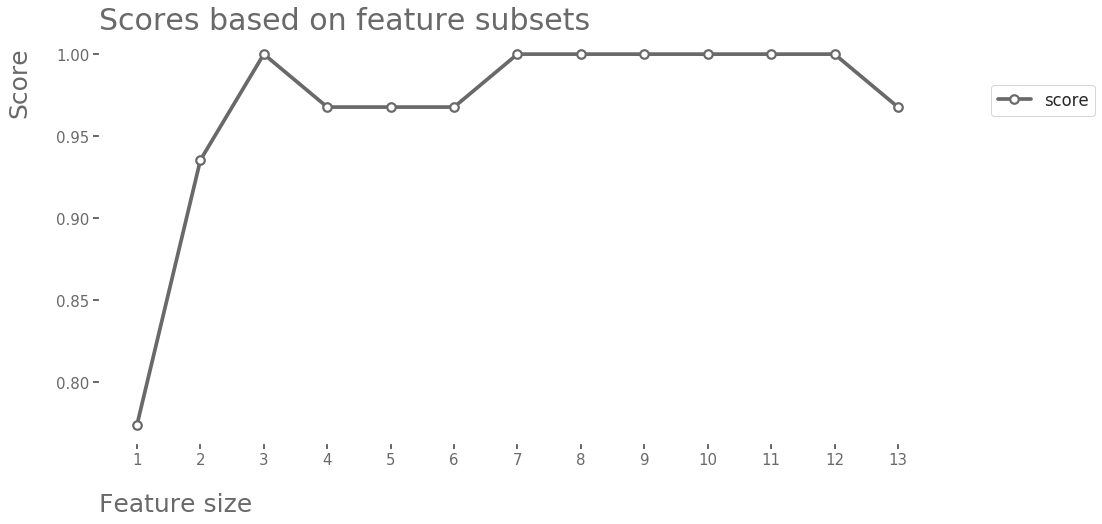

In [30]:
# plot score by feature subset size
p = PrettierPlot()
ax = p.make_canvas(
    title="Scores based on feature subsets",
    xLabel="Feature size",
    yLabel="Score",
    y_shift=0.8,
)

k_feat = [len(k) for k in sbs.subsets_]

p.prettyLine(
    x=np.array(k_feat),
    y=np.array(sbs.scores_),
    xTicks=np.arange(1, 14, 1),
    y_units="fff",
    label="score",
    markerOn=True,
    ax=ax,
)

> Remarks - It's clear, based on the graphic above, that the accuracy of the model increased as the number of features was reduced fro  13 to 12. This is likely due to the curse of dimensionality effect being reduced. The model achieved 100% accuracy on $k = [3,7,8,9,10,11,12]$

In [31]:
# details for the smallest feature subset
k3 = list(sbs.subsets_[10])
print(df_wine.columns[1:][k3])

Index(['alcohol', 'malic_acid', 'od280/od315_of_diluted_wines'], dtype='object')


In [32]:
# evaluate KNN erformance on full data set
knn.fit(X_train_sc, y_train)
print("Training accuracy:", knn.score(X_train_sc, y_train))
print("Test accuracy:", knn.score(X_test_sc, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [33]:
# evaluate KNN erformance on full data set
knn.fit(X_train_sc[:, k3], y_train)
print("Training accuracy:", knn.score(X_train_sc[:, k3], y_train))
print("Test accuracy:", knn.score(X_test_sc[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


> Remarks - The model which uses less than one quarter of the original features peforms slightl worse. While the smaller feature set did not outperform the original, we significantly shrank the size of the data set. Simpler models are also easier to interpret. These advantages should be weighed against the decrease in performance.

#  Assessing feature importance with random forests

The scikit-learn implementation of RandomForest captures the importance of features. This attribute includes the averaged impurity decrease computered from all decision tress in the forest.

<a id = 'Assessing-feature-importance-with-random-forests'></a>

In [34]:
# display feature importances
feat_labels = df_wine.columns[1:]
forest = ensemble.RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(
        "%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]])
    )

 1) proline                        0.185453
 2) flavanoids                     0.174751
 3) color_intensity                0.143920
 4) od280/od315_of_diluted_wines   0.136162
 5) alcohol                        0.118529
 6) hue                            0.058739
 7) total_phenols                  0.050872
 8) magnesium                      0.031357
 9) malic_acid                     0.025648
10) proanthocyanins                0.025570
11) alcalinity_of_ash              0.022366
12) nonflavanoid_phenols           0.013354
13) ash                            0.013279


In [35]:
feat_labels

Index(['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium',
       'total_phenols', 'flavanoids', 'nonflavanoid_phenols',
       'proanthocyanins', 'color_intensity', 'hue',
       'od280/od315_of_diluted_wines', 'proline'],
      dtype='object')

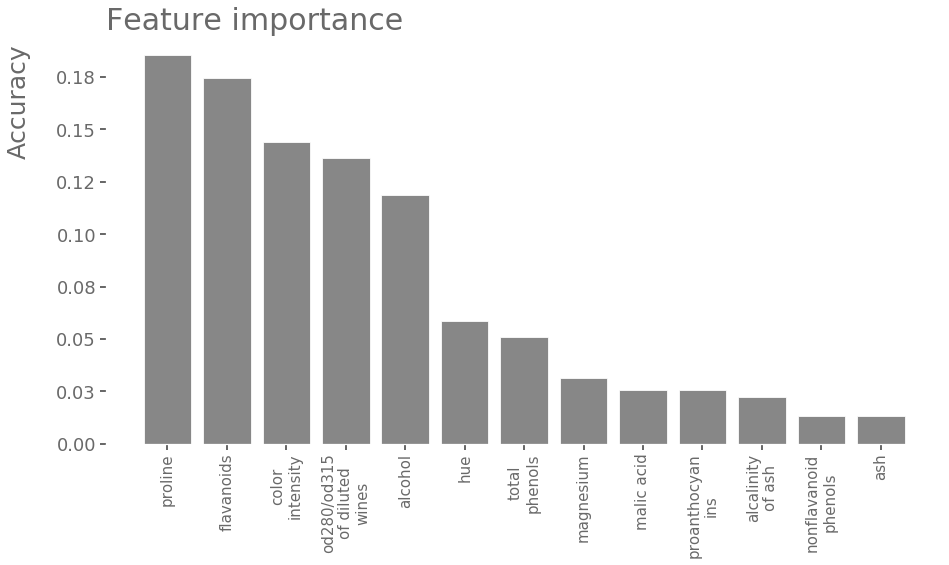

In [36]:
# plot feature importance value by feature
p = PrettierPlot()
ax = p.make_canvas(title="Feature importance", yLabel="Accuracy", y_shift=0.7)
p.prettyBarV(
    x=np.arange(1, len(indices) + 1),
    counts=importances[indices],
    xLabels=feat_labels[indices],
    labelRotate=90,
    y_units="fff",
    ax=ax,
)

> Remarks - Proline, flavanoids, color_intensity, OD280/OD315 diffraction and alchohol concentration are the most informative features in the dataset based on average impurity decrease across the 500 trees. Further, This set of features shares two features with the SBS feature subset selection. One important thing to note is that if two or more features are highly correlated, RandomForest will tend to rank one feature very highly while not fully capturing the other(s). This detracts from interpretability, but not from predictive performance.